# <center>M2 DAC -   Reinforcement Learning & Advanced Deep</center>
##  <center> TME 9. Generative Adversarial Networks  </center>

Ce TME a pour objectif d'expérimenter les Generative Adversarial Networks (GANs) sur un problème de génération de visages. 

De manière classique, un GAN se formule selon un problème adverse de la manière suivante: 
$$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$$
Cette formulation met en jeu deux réseaux adverse: 
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les données réelles des données simulées  
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des données générées par $G$ est prouvée suivre la distribution des données réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par coeur les données d'apprentissage), mais l'objectif est d'approcher cette distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties sont difficilement distinguables des vraies données pour le discriminateur. 

Nous proposons de mettre ce genre d'architecture pour un la génération de visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à générer des visages qui paraissent les plus réalistes possibles tout en conservant une certaine diversité dans les distributions de sortie. Pour cela nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones convolutionnels (CNNs) pour le générateur et le discriminateur.    


 



Pour ce TP, nous vous proposons de travailler avec Google Colab qui est un service notebook en ligne avec ressources machines à disposition (nécessite d'être connecté à un compte google personnel):
*   https://colab.research.google.com/
*   Ouvrir ce Notebook avec "File>Upload Notebook"
*   Sélectionner un Runtime GPU : Runtime>Change Runtime Type (utile de le faire avant tout téléchargement de données car le changement de Runtime efface les données temporaires de la session)

Pour télécharger les données utiles au TP: 


*   Aller à l'adresse : https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8
*   Clic-droit sur CelebA, Ajouter à mon Drive
*   Exécuter le code ci-dessous (une autorisation vous sera demandée, suivre le lien donné à l'exécution pour obtenir le code d'authentification)

(Sinon vous pouvez aussi travailler en local en téléchargeant les données sur votre ordinateur mais attention fichier volumineux et colab propose des ressources GPU utiles à la résolution du TP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Vous devez maintenant avoir dans le paneau de gauche un onglet Files contenant un répertoire drive dans l'arborescence. C'est votre espace de stockage Google Drive. Il devrait contenir un répertoire CelebA (si ce n'est pas le cas attendre un peu et rafraichir, il peut mettre un certain temps à apparaître). 

Il s'agit maintenant de décompresser l'archive téléchargée (cela peut prendre jusqu'à une dizaine de minutes): 



In [ ]:
!unzip drive/My\ Drive/CelebA/Img/img_align_celeba -d data

Cela produit un répertoire data à la racine du repertoire temporaire de votre Google Colab. Ce repertoire contient un sous-repertoire img_align_celeba contenant une liste de 202599 fichiers jpg correspondant à des photos de visages de célébrités (attention ce repertoire est temporaire, tout ce qui n'est pas dans un drive est effacé à la fin de la session). 



In [1]:
import random
import numpy as np
try:
    import torch
except:
    !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Le code ci-dessous permet de déclarer la manière de charger les données. 

Lorsque des données sont demandées (pour la construction d'un nouveau batch par exemple), une série de transformations est appliquée sur les images, selon la composition de transformateurs déclarée pour le chargement: 
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch 
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type de 0.5.



In [2]:
image_size = 64
dataset = dset.ImageFolder(root="data",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [3]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 126444
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Le code ci-dessous permet de déclarer la manière de charger les images et en affiche un échantillon. 

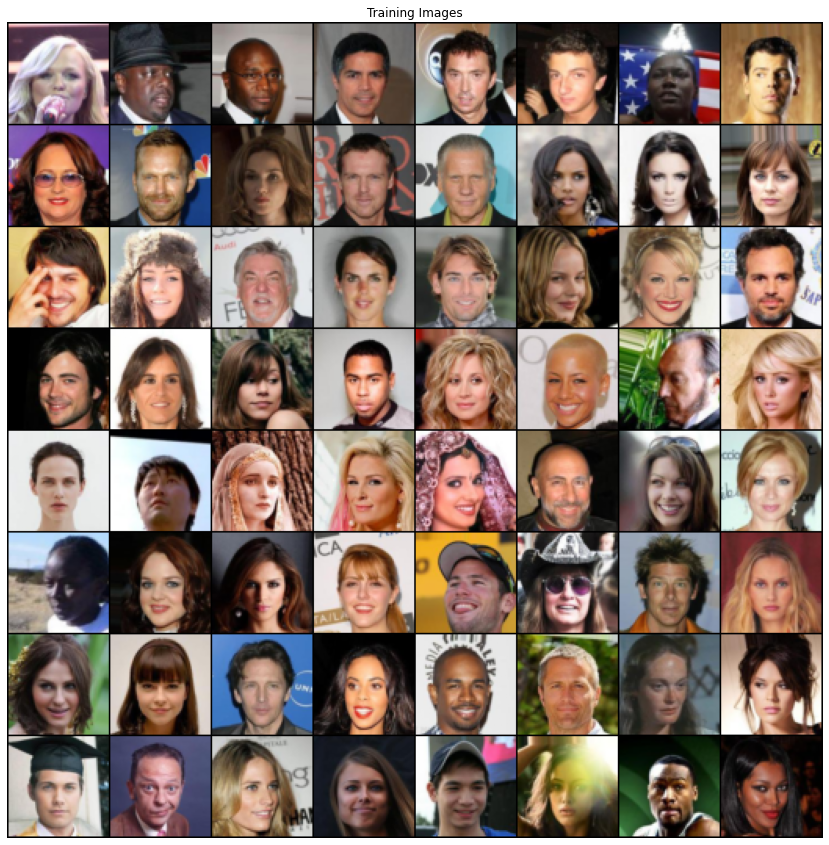

In [4]:
import matplotlib.pyplot as plt
import os

seed=0
torch.manual_seed(seed)
np.random.seed(seed)
device=0
if device>=0 and torch.cuda.is_available():
  cudnn.benchmark = True
  torch.cuda.device(device)
  torch.cuda.manual_seed(seed)
else: 
  device=-1

batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Affichage de quelques images
real_batch = next(iter(dataloader)) #real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)

plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
os.makedirs("./genFaces",exist_ok=True)
plt.savefig("./genFaces/train.png" ) # Pour sauvegarder l'image sur votre Google Drive 


In [5]:
real_batch = next(iter(dataloader))
real_batch[0].size()

torch.Size([128, 3, 64, 64])

In [6]:
real_batch[0][0].mean((1,2))

tensor([-0.3175, -0.5756, -0.7563])

Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D et activations RELU: 

In [7]:

nc = 3 # Nombre de canaux de l'entrée
ndf = 64 # Facteur du nombre de canaux de sortie des différentes couches de convolution


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Loss Functions and Optimizers


With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
(`BCELoss <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>`__)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.

Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour chaque nouveau batch d'images, on alterne les deux mises à jour suivantes, selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale centrée réduite (un nouveau batch de $z$ à chaque itération): 

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:  $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour maximiser:  $log(D(G(z)))$ 


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne des sorties du discriminateur sur les images réelles et la moyenne des sorties du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du DataLoader), on pourra enregistrer les images générées à partir d'un batch de vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités du générateur.  



## Training
Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as @@11@@
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.

In [9]:
# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Training Loop
writer = SummaryWriter(log_dir="./GAN")
# Lists to keep track of progress
# img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        writer.add_scalar('mean_real_D', D_x, iters)
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device, dtype=torch.float)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z = output.mean().item()
        writer.add_scalar('mean_fake_D', D_G_z, iters)
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        writer.add_scalar('D_loss', errD, iters)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        writer.add_scalar('G_loss', errG, iters)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z, D_G_z2))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            grid = torchvision.utils.make_grid(fake)
            writer.add_image(f'fake images {iters}', grid, iters)
            # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/988]	Loss_D: 1.2236	Loss_G: 3.3911	D(x): 0.9142	D(G(z)): 0.5681 / 0.0702
[0/5][50/988]	Loss_D: 0.4825	Loss_G: 3.6935	D(x): 0.8954	D(G(z)): 0.2777 / 0.0385
[0/5][100/988]	Loss_D: 0.5017	Loss_G: 3.2569	D(x): 0.8355	D(G(z)): 0.2347 / 0.0552
[0/5][150/988]	Loss_D: 0.7228	Loss_G: 2.9625	D(x): 0.7987	D(G(z)): 0.3228 / 0.0798
[0/5][200/988]	Loss_D: 0.7009	Loss_G: 3.4468	D(x): 0.8661	D(G(z)): 0.3738 / 0.0512
[0/5][250/988]	Loss_D: 0.5557	Loss_G: 1.5154	D(x): 0.7043	D(G(z)): 0.1442 / 0.2566
[0/5][300/988]	Loss_D: 0.5765	Loss_G: 2.8499	D(x): 0.7769	D(G(z)): 0.2273 / 0.0803
[0/5][350/988]	Loss_D: 0.6987	Loss_G: 4.4704	D(x): 0.9059	D(G(z)): 0.4149 / 0.0180
[0/5][400/988]	Loss_D: 1.0901	Loss_G: 5.0522	D(x): 0.9511	D(G(z)): 0.5852 / 0.0112
[0/5][450/988]	Loss_D: 1.3250	Loss_G: 0.1744	D(x): 0.3398	D(G(z)): 0.0277 / 0.8510
[0/5][500/988]	Loss_D: 0.5320	Loss_G: 2.2071	D(x): 0.7211	D(G(z)): 0.1449 / 0.1448
[0/5][550/988]	Loss_D: 0.5775	Loss_G: 3.3544	D(x): 0.8498	D(G(z)

Le code ci-dessous applique votre réseau à un batch de $z$ aléatoires et affiche les images générées (et enregistre dans fake.png). 

In [8]:
noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
  netG.eval()
  fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "fake.png" )


NameError: name 'img_list' is not defined

Le générateur du papier original DCGAN possède en fait l'architecture suivante: 

![Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Comme le réseau $G$ définit plus haut, il correspond à un empilement de couches de convolutions transposées (appelée dans certains papiers couches de déconvolution). Contrairement aux convolutions classiques qui mènent à une réduction de la taille des sorties, les convolutions transposées agrandissent les cartes de caractéristiques considérées (feature maps). C'est particulièrement adapté pour de la génération d'images à partir d'un code de petite taille (ici $z$). 

 Pour comprendre comment fonctionne la convolution transposée, voici un exemple simple avec une entrée 2 x 2 et un noyau 2 x 2. Chaque élément de l'entrée (4 éléments) est multiplié par le noyau et le résultat est ajouté à la sorte de taille 3 x 3: 

![BasicTransposeConv2D](http://d2l.ai/_images/trans-conv.svg)

Et voici deux animations pour se représenter l'opération d'une manière plus générale. A gauche on utilise un stride de 1, à droite un stride de 2: 

<p align="center">
<img src="https://i.stack.imgur.com/YyCu2.gif">
<img src="https://i.stack.imgur.com/f2RiP.gif">
</p>


Suivant la doc Pytorch de torch.nn.ConvTranspose2d, la hauteur $H_{out}$ et la largeur $W_{out}$ des cartes de sortie du ConvTranspose2d peuvent se calculer de la manière suivante: 

$H_{out}$=($H_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

$W_{out}$=($W_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1


Proposer un nouveau réseau $G$ qui respecte l'architecture du schéma du papier DCGAN et comparer les résultats. On gardera le paramètre de dilation à sa valeur de 1 par défaut mais il est possible de moduler les valeurs de padding et output_padding pour obtenir des sorties de la taille désirée. 


Bonus: Réaliser le même genre d'apprentissage sur le corpus Mnist (Dataloader existant dans torch pour télécharger et charger le corpus)